# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

Devloped by **Gangadhar Kadam** in **December 2017** through the **Udacity Self Driving Car Engineer Nanodegree***
***
In this project, I developed a pipeline on a series of individual images, and later applied the result to a video stream (really just a series of images). I validated the my result with "raw-lines-example.mp4"  test video provided in the project. When the result looked roughly same as the test video, I tried to average and/or extrapolate the line segments I detected to map out the full extent of the lane lines. 

The pipeline is as follows:
1. Apply a Gaussian smoothing algorithm to cleanup the image and noise removal
2. Convert the image to grayscale
3. Apply Canny edge detection algorithm to detects the edges
4. Apply an image mask to get "region of interest" in front of the vehicle
5. Apply Hough ransform algorith to identify the location of lane lines
6. Get the list of lines and line slopes for averaging
7. Average the line positions
8. Remove outlier slopes from the line averaging
9. Extrapolate the line boundaries
10. get the final image with the weighted average

---

## Import Packages

In [1]:
#importing some of the useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import math
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


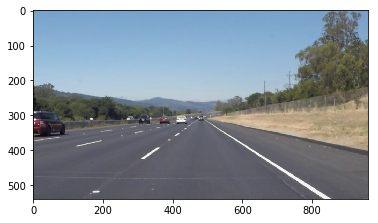

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

# Alogorithms and Packages used

**I have leveraged some of the below popular algorithms and packages:**
- `OpenCV` - Algorithms for Computer Vision 
    - `cv2.inRange()` for color selection  
    - `cv2.fillPoly()` for regions selection  
    - `cv2.line()` to draw lines on an image given endpoints  
    - `cv2.addWeighted()` to coadd / overlay two images 
    - `cv2.cvtColor()` to grayscale or change color 
    - `cv2.imwrite()` to output images to file  
    - `cv2.bitwise_and()` to apply a mask to an image 
- `NumPy` - Algorithms for Scientifc computation 
- `SciPy` - Algorithms for Scientifc computation 
- `Matplotlib` - A Python 2D plotting library 
- `Pyplot` - A Python library for interactive plot generation 
- `Gaussian blur` - Algorithms for Image processing 
- `Canny` - Algorithm for edge detection in an image 
- `Hough transform` - An algorithm to identify location of lane lines on the Road

## Functions Used

In [3]:
class Smooth:
    def __init__(self, windowsize=10):
        self.window_size = windowsize
        self.data = np.zeros((self.window_size, 2, 4), dtype=np.float32)
        self.index = 0
    
    def __iadd__(self, x):
        if self.index == 0:
            self.data[:] = x
        self.data[self.index % self.window_size] = x
        self.index += 1
        return self

# Define a function to Apply a Gaussian Noise kernel
def gaussian_blur(image, kernel_size):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

# Define a Function to convert the image to grayscale
# This will return an image with only one color channel
def gray_scale_transform(image):
    #use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


# Define a function to Apply the Canny transformation
def detect_edges(image, low_threshold, high_threshold):
    return cv2.Canny(image, low_threshold, high_threshold)

# Function to get the region of interest by applying an image mask
# Only keeps the region of the image defined by the polygon formed from `vertices`. 
# The rest of the image is set to black.
def region_of_interest(image, vertices):

    #defining a blank mask to start with
    mask = np.zeros_like(image)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

# draw lines
def draw_lines(img, lines, color=[255, 0, 0], thickness=20):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
# Identify the location of lane lines on the road
def hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
   
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_image(image, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, image, β, λ)



#Removing outlier slopes from the averaging performed below in lane_lines
def remove_outliers(slopes, m = 2):
    med = np.mean(slopes)
    stand_dev = np.std(slopes)
    for slope in slopes:
        if abs(slope - med) > (m * stand_dev):
            slopes.remove(slope)
    return slopes

## Test On Images

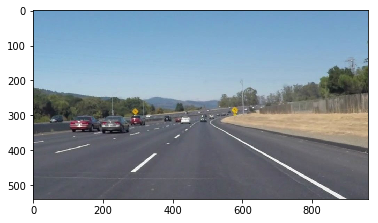

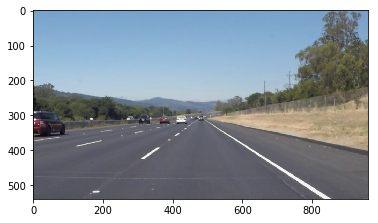

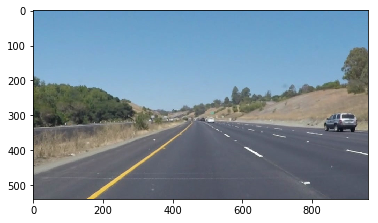

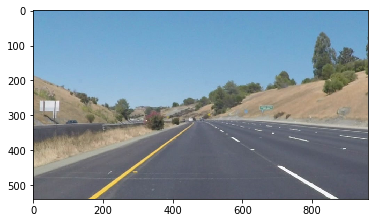

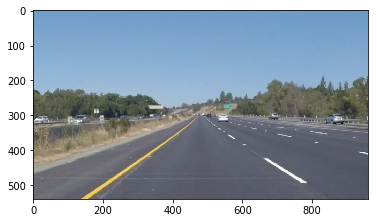

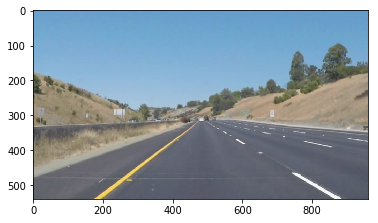

In [4]:

#Importing the images, and let's take a look at what we have!
import os
test_pics = os.listdir("test_images/")

for i in test_pics:
    i = 'test_images/' + i
    image = mpimg.imread(i)
    plt.imshow(image)
    plt.show()

## The Pipline
I added all the primary functions I wanted to use into the below **get_lane_lines(image)** function, which I will later **call to process images for the video**.


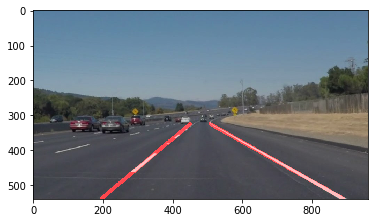

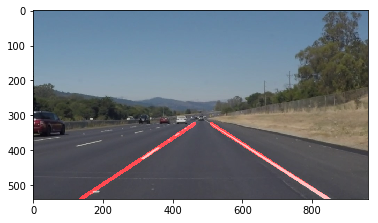

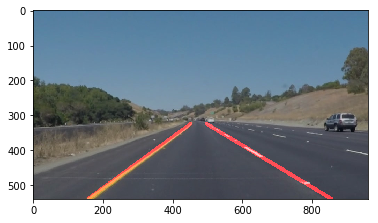

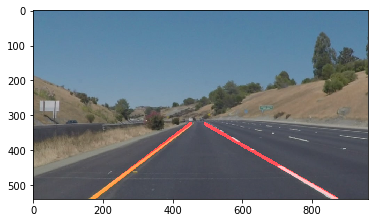

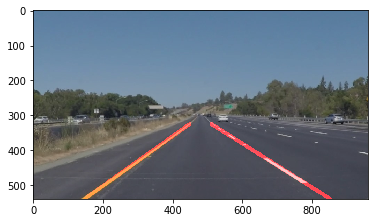

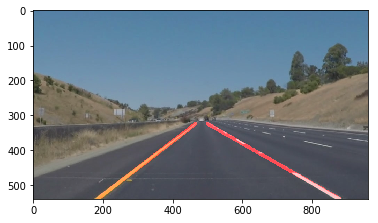

In [50]:
# The below function combine all the helper functions as necessary
# Gray-scale, smoothing, canny edge, masking, hough-transform
# Then take the resulting lines and slopes, remove outliers
# Finally, extrapolate the lines based on the average slope and midpoint of the average lane line on each side


def get_lane_lines(image):
    
    global height, width
    
    # grayscale the image
    grayscaled = gray_scale_transform(image)

    # apply gaussian Smooth with Gaussian Blur
    kernelSize = 7
    blur_gray = gaussian_blur(grayscaled, kernelSize)

    # Add in the canny edge detection
    # Define  parameters for Canny
    low_threshold = 50
    high_threshold = 150
    


    # Apply the cany transformation
    edges = detect_edges(blur_gray, low_threshold,high_threshold)

    # Now the masking
    # calculate vertices for region of interest
    imshape = image.shape
    
    height = image.shape[0]
    width = image.shape[1]
    
    vertices = np.array([[(0, height), (width*3/8, height*5/8), (width*5/8, height*5/8), (width, height)]], dtype=np.int32)
    #vertices = np.array([[(0,imshape[0]),(450, 325), (550, 325), (imshape[1],imshape[0])]], dtype=np.int32)

    # return the image only where mask pixels are nonzero
    masked_img = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    # hough lines
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10 #50     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 20 #25 #minimum number of pixels making up a line
    max_line_gap = 1 #25    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    #lines = hough_lines(masked_img, rho, theta, threshold, min_line_len, max_line_gap)
    lines = cv2.HoughLinesP(masked_img, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
    
    #Make lists of the lines and slopes for averaging
    left_lines = []
    left_slopes = []
    right_lines = []
    right_slopes = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope < 0:
                left_lines.append(line)
                left_slopes.append(slope)
            else:
                right_lines.append(line)
                right_slopes.append(slope)
    
    #Average line positions
    avg_left_pos = [sum(col)/len(col) for col in zip(*left_lines)]
    avg_right_pos = [sum(col)/len(col) for col in zip(*right_lines)]
    
    #Remove slope outliers, and take the average
    avg_left_slope = np.mean(remove_outliers(left_slopes))
    avg_right_slope = np.mean(remove_outliers(right_slopes))
    
    #Extrapolate to our mask boundaries - up to 325, down to 539
    avg_left_line = []
    for x1,y1,x2,y2 in avg_left_pos:
        x = int(np.mean([x1, x2])) #Midpoint x
        y = int(np.mean([y1, y2])) #Midpoint y
        slope = avg_left_slope
        b = -(slope * x) + y #Solving y=mx+b for b
        avg_left_line = [int((325-b)/slope), 325, int((539-b)/slope), 539] #Line for the image 
    
    #Same thing for the right side
    avg_right_line = []
    for x1,y1,x2,y2 in avg_right_pos:
        x = int(np.mean([x1, x2]))
        y = int(np.mean([y1, y2]))
        slope = avg_right_slope
        b = -(slope * x) + y
        avg_right_line = [int((325-b)/slope), 325, int((539-b)/slope), 539]
    
    lines = [[avg_left_line], [avg_right_line]]
    
    draw_lines(line_image, lines,color=[255, 0, 0], thickness=10)

    # Transparent lines
    line_edges = weighted_image(line_image, image)
    
    return line_edges

#Pull each image and show it to see how it performed 
for i in test_pics: 
    i = 'test_images/' + i
    image = mpimg.imread(i)
    plt.imshow(get_lane_lines(image))
    plt.show()


## Test on Videos

Lets work on the really cool part of the project - Drawing the lanes over video!

I Tested my solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [51]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [52]:

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = get_lane_lines(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [53]:
a = Smooth(windowsize=5)
white_output = 'white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4



100%|█████████▉| 221/222 [00:06<00:00, 32.13it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.93 s, sys: 949 ms, total: 3.88 s
Wall time: 7.63 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [54]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Optimize the draw_lines() function

**I worked upon the below improvements on my draw_line function.**
1. Tried to identify the full extent of the lane and marking it clearly (Ref: P1_example.mp4 video)  
2. Tried to define a line to run the full length of the visible lane based on the line segments I identified with the Hough Transform. 
3. Tried to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. (Ref. Video - "P1_example.mp4".**)


Now for the one with the solid yellow lane on the left. This one's was more tricky!

In [55]:
image = mpimg.imread('test_images/solidYellowLeft.jpg')
a = Smooth(windowsize=5)
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)


[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4



 94%|█████████▍| 644/682 [00:18<00:01, 34.38it/s]


100%|█████████▉| 681/682 [00:20<00:00, 33.95it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 8.98 s, sys: 2.23 s, total: 11.2 s
Wall time: 20.8 s


In [43]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))